# Circuit of Hamiltonian Simulation using Qiskit

This notebook will teach you how to construct your own circuits for the Hamiltonian Simulation using Qiskit.

# Install Qiskit

Install Qiskit if you haven't. Here we are not installing the latest version of Qiskit since it has an issue with displaying circuits using matplotlib (fancy circuits) in Colab.

In [ ]:
!pip install qiskit==0.16.1

# Importing Packages

In [ ]:
from qiskit import * # No need to explain why
import matplotlib as mpl # Required to display some fancy circuits
from scipy.linalg import expm
import numpy as np

In [ ]:
# We need these for verifying our circuits later
Z_gate = np.matrix([[1, 0], [0, -1]])
X_gate = np.matrix([[0, 1], [1, 0]])
Y_gate = np.matrix([[0, -1j], [1j, 0]])

# The problem

Now we move on to the main section. In this notebook, we will explain the construction and implementation of basic Hamiltonian simulation circuits. The problem can be defined as follow: For a Hamiltonian $H$ acting on $n$ qubits, can we implement the operator (gate) $e ^ {-iHt}$, for any $t \geq 0 $? Throughout this notebook, we will be dealing with simple Hamiltonians acting on $3$ qubits.

# Product Forms

We start with Hamiltonians that have a product form, by which, we mean Hamiltonians $H = A \otimes B \otimes C$, where $A, B, C \in \{ I, X, Y, Z\}$.  

## Example 1

Our first example is $H = Z \otimes Z \otimes Z$. The circuit implementing $e ^ {iHt}$ in this case is given as

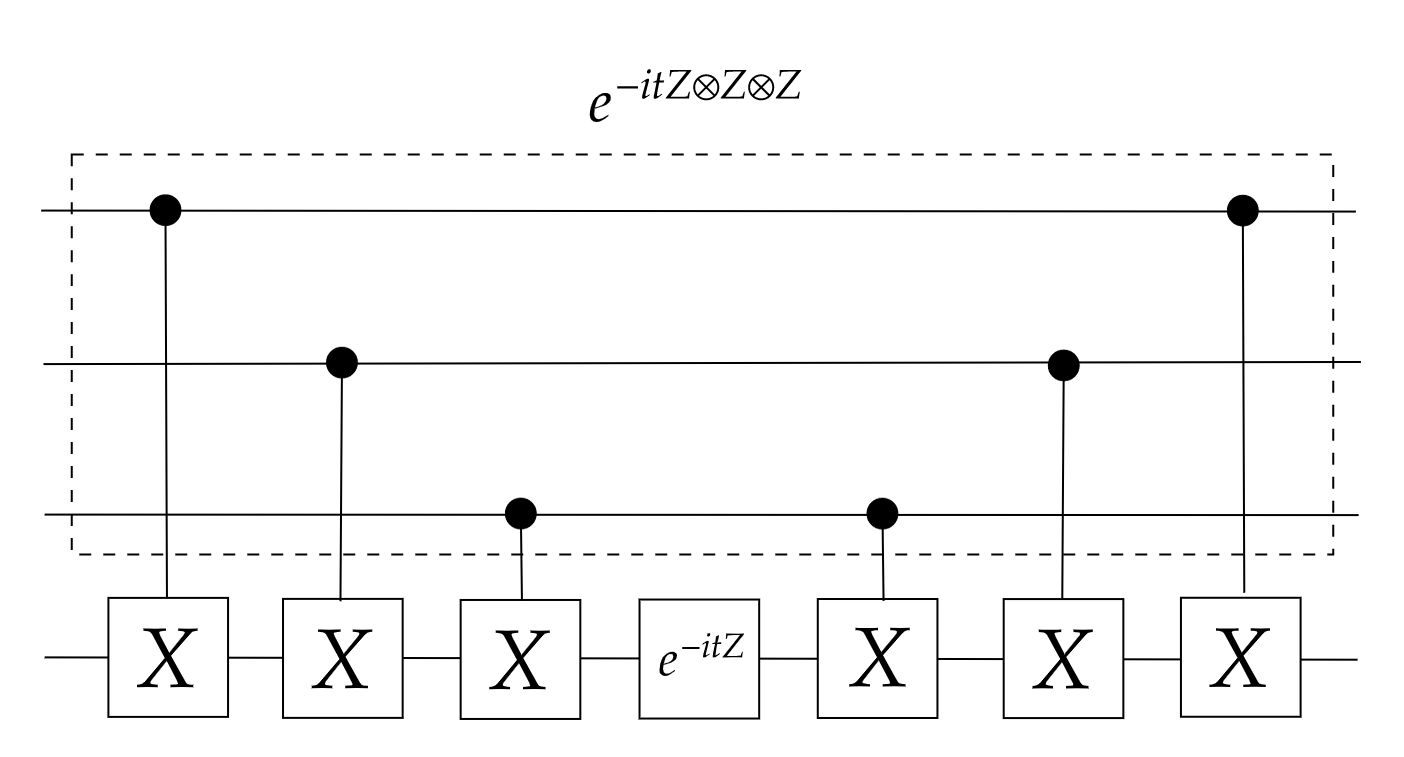

The gate $e ^ {-iZt}$ can be implemented by the $U1$ gate in Qiskit, whose form is

\begin{equation}
  U1(\theta) = 
  \begin{bmatrix}
    1 & 0 \\
    0 & e ^ {i \theta}
  \end{bmatrix}
\end{equation}

This gate is equivalent to the rotation around Z axis (which is $e ^ {\frac{-iZ\theta}{2}}$) by a constant factor as

\begin{equation}
  U1(\theta) = e ^ {\frac{i \theta}{2}} R_Z(\theta)
\end{equation}

So, to implement $e ^ {-iZt}$, we can use $U1(2t)$. In our example, let $t = 1$.

Now we move on to the construction of this circuit. Before that, assign $t = 1$.

In [ ]:
t = 1

First, we prepare the quantum register. As we can see, from the circuit, the quantum register comprises of 4 qubits. Hence

In [ ]:
# Prepare the circuit
qr = QuantumRegister(4)

Using the quantum register, we now define the quantum circuit

In [ ]:
# Prepare quantum circuit
qc = QuantumCircuit(qr)

Now, we shall start applying the gates. We start with the first $3$ CNOT gates. 

In [ ]:
# Apply the first 3 CNOT gates
qc.cnot(0, 3)
qc.cnot(1, 3)
qc.cnot(2, 3)

Then, we apply the U1 gate.

In [ ]:
# Apply the U1 gate
qc.u1(2 * t, 3)

Now, we apply the next $3$ CNOT gates.

In [ ]:
# Apply the next 3 CNOT gates
qc.cnot(2, 3)
qc.cnot(1, 3)
qc.cnot(0, 3)

Let's preview the circuit we have built so far.

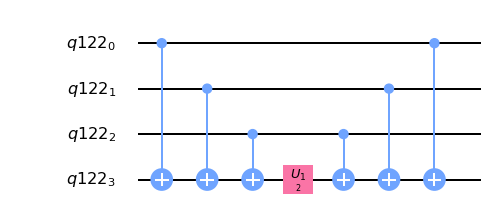

In [ ]:
# DIsplay the circuit
qc.draw(output = "mpl")

Looks good. Now that we have successfully constructed the circuit, let's move on to verify whether the circuit we have built is actually $e ^ {-iZ \otimes Z \otimes Z}$. For that, first we need the actual matrix $e ^ {-iZ \otimes Z \otimes Z}$.

In [ ]:
actual_matrix = expm(-1j * (np.kron(np.kron(Z_gate, Z_gate), Z_gate)))

Ok. Now, we shall execute our quantum circuit on each of the $8$ basis states to get the column of the operator, and in each case, compare the norm of the difference between that and the actual columns of "actual_matrix". That is, let $G$ be the unitary made by the circuit. For every $i \in \{ 0,1, \dots, 7\}$, we shall compute 

\begin{equation}
  \Big| \Big| G|i\rangle - \text{actual_matrix}[:,i]\Big| \Big|_2^2
\end{equation}

If all of these values are $0$, then we have succesfully implemented $e ^ {-iZ \otimes Z \otimes Z}$.

In [ ]:

# This function converts a decimal number to its binary expansion
def Binary(x, BitNo):
  format(x, 'b').zfill(BitNo)
  Binlist = [int(y) for y in list(format(x, 'b').zfill(BitNo))]
  return Binlist

for i in range(8):

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  qr = QuantumRegister(4)
  qc = QuantumCircuit(qr)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      qc.x(j)

  # Apply circuit
  qc.cnot(0, 3)
  qc.cnot(1, 3)
  qc.cnot(2, 3)
  qc.u1(2 * t, 3)
  qc.cnot(2, 3)
  qc.cnot(1, 3)
  qc.cnot(0, 3)

  # Compute the state vector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()
  
  # Disply the norm. Note that the global phases that each of the U1 gates brings in have to be removed. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm((np.exp(-1j * t) * statevector[:8]) - actual_matrix[:,i]) ** 2)


0.0
1.232595164407831e-32
1.232595164407831e-32
0.0
1.232595164407831e-32
0.0
0.0
1.232595164407831e-32


Since all outputs are $0$, we can safely say that the circuit we have prepared is actually $e ^ {-iZ \otimes Z \otimes Z}$.

## Example 2

Our second example is $H = Z \otimes X \otimes Y$. The circuit implementing $e ^ {iHt}$ in this case is given as

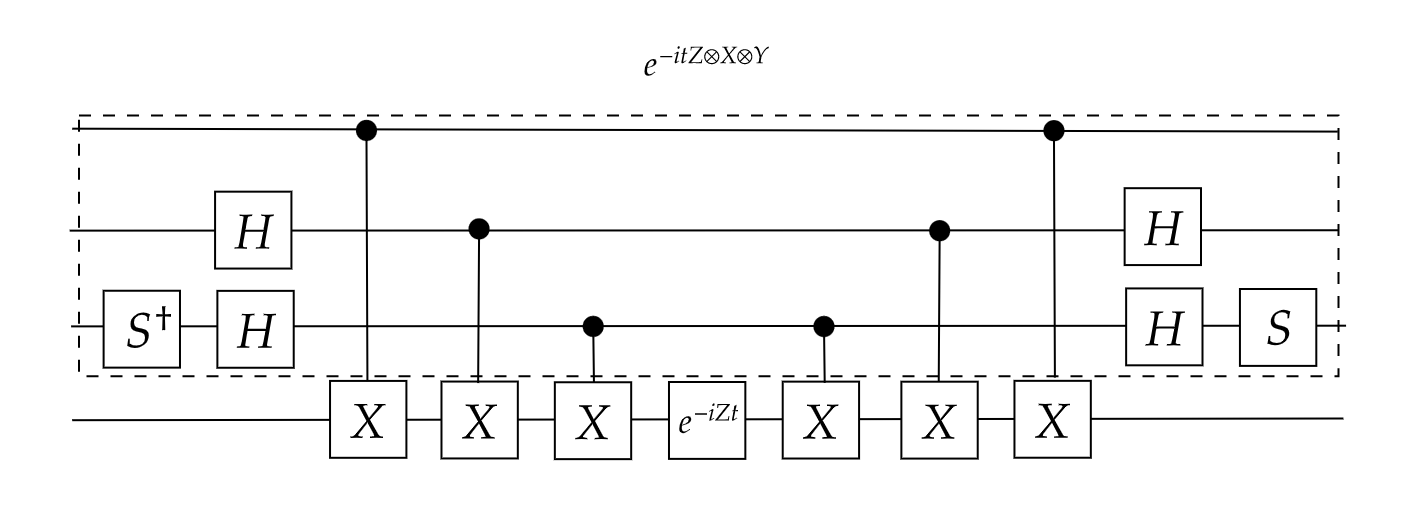

In this case, let $t = 0.5$. Since we have already explained the construction and verification of the previous Hamiltonian in detial, we shall directly go into the verification here, since the differences are minor.

2.4385213423259145e-16
2.877364037054095e-16
3.539397238604554e-16
3.6762873460745315e-16
3.333794171824629e-16
3.0254889973282445e-16
4.324822125912658e-16
4.885643173899639e-16


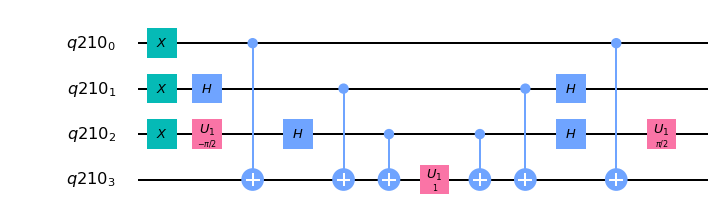

In [ ]:
# Assign t = 0.5
t = 0.5

# Since Z is acting on qubit 1, the actual_matix in this case will have the form
actual_matrix = expm(-1j * 0.5 * (np.kron(np.kron(Y_gate, X_gate), Z_gate)))

for i in range(8):
  # Prepare the circuit
  qr = QuantumRegister(4)
  qc = QuantumCircuit(qr)

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      qc.x(j)

  # Apply circuit
  qc.u1(-np.pi/2, 2)
  qc.h(1)
  qc.h(2)

  qc.cnot(0, 3)
  qc.cnot(1, 3)
  qc.cnot(2, 3)
  qc.u1(2 * t, 3)
  qc.cnot(2, 3)
  qc.cnot(1, 3)
  qc.cnot(0, 3)

  qc.h(1)
  qc.h(2)
  qc.u1(np.pi/2, 2)

  # Compute the state vector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()
  #print(np.exp(-1j * t) * statevector[:8])

  print(np.linalg.norm((np.exp(-1j * t) * statevector[:8]) - actual_matrix[:,i]))

# DIsplay the circuit
qc.draw(output = "mpl")


Here also, since all outputs are $0$, we can safely say that the circuit we have prepared is actually $e ^ {-iZ \otimes X \otimes Y}$.

# Sum of product Hamiltonians

In this section, we shall try simulating a Hamiltonian which can be written as the sum of $2$ product Hamiltonians.

## Sum of commuting product Hamiltonians

First we shall try a Hamiltonian which can be written as a sum of two commuting product Hamiltonians. We have already simulated Hamiltonians $H_1 = Z \otimes Z \otimes Z$ and $H_2 = Z \otimes X \otimes Y$. Since these two matrices commute, let's try simulating the Hamiltonian $H = H_1 + H_2$ as $e ^ {-iH_2t} e ^ {-iH_1t} $. Let's take $t = 2$. Note that, in this case, we just have to apply both circuits one after the other.

1.2156483436458428e-31
1.4096729832185154e-31
2.7084906051579623e-31
1.7954550442106914e-31
1.4343185235986923e-31
1.0600810119887717e-31
9.643278715761253e-32
2.4808499033385493e-31


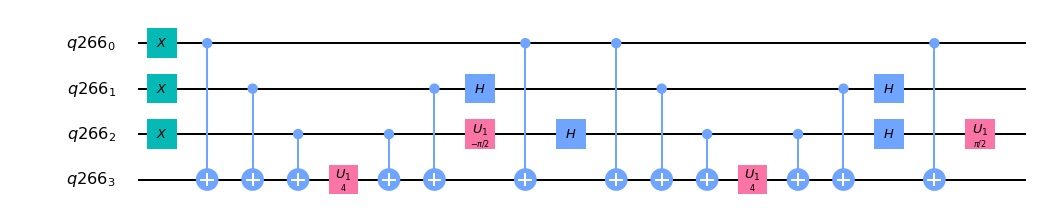

In [ ]:
# Assign t = 2
t = 2

# Actual matrix is given as
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), Z_gate)))

for i in range(8):

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  qr = QuantumRegister(4)
  qc = QuantumCircuit(qr)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      qc.x(j)

  # Apply H1
  qc.cnot(0, 3)
  qc.cnot(1, 3)
  qc.cnot(2, 3)
  qc.u1(2 * t, 3)
  qc.cnot(2, 3)
  qc.cnot(1, 3)
  qc.cnot(0, 3)

  # Apply H2
  qc.u1(-np.pi/2, 2)
  qc.h(1)
  qc.h(2)

  qc.cnot(0, 3)
  qc.cnot(1, 3)
  qc.cnot(2, 3)
  qc.u1(2 * t, 3)
  qc.cnot(2, 3)
  qc.cnot(1, 3)
  qc.cnot(0, 3)

  qc.h(1)
  qc.h(2)
  qc.u1(np.pi/2, 2)

  # Compute the state vector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()
  
  # Disply the norm. Note that the global phases that each of the U1 gates brings in have to be removed. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm((np.exp(-1j * t * 2) * statevector[:8]) - actual_matrix[:,i]) ** 2)

# Display the circuit
qc.draw(output = "mpl")

As expected, we are able to perfectly simulate the unitary $e ^ {-iHt}$.

## Sum of non-commuting product Hamiltonians

Now let's move on to a case where we have a Hamiltonian written as a sum of two non-commuting Hamiltonians. Let $H = H_1 + H_2$, where $H_1 = X \otimes Z \otimes Z$ and $H_2 = Z \otimes X \otimes Y$. One can see that $H_1$ and $H_2$ are actually non-commuting matrices. Let $t$ be 1. Here, $H_1$ can implemented as 

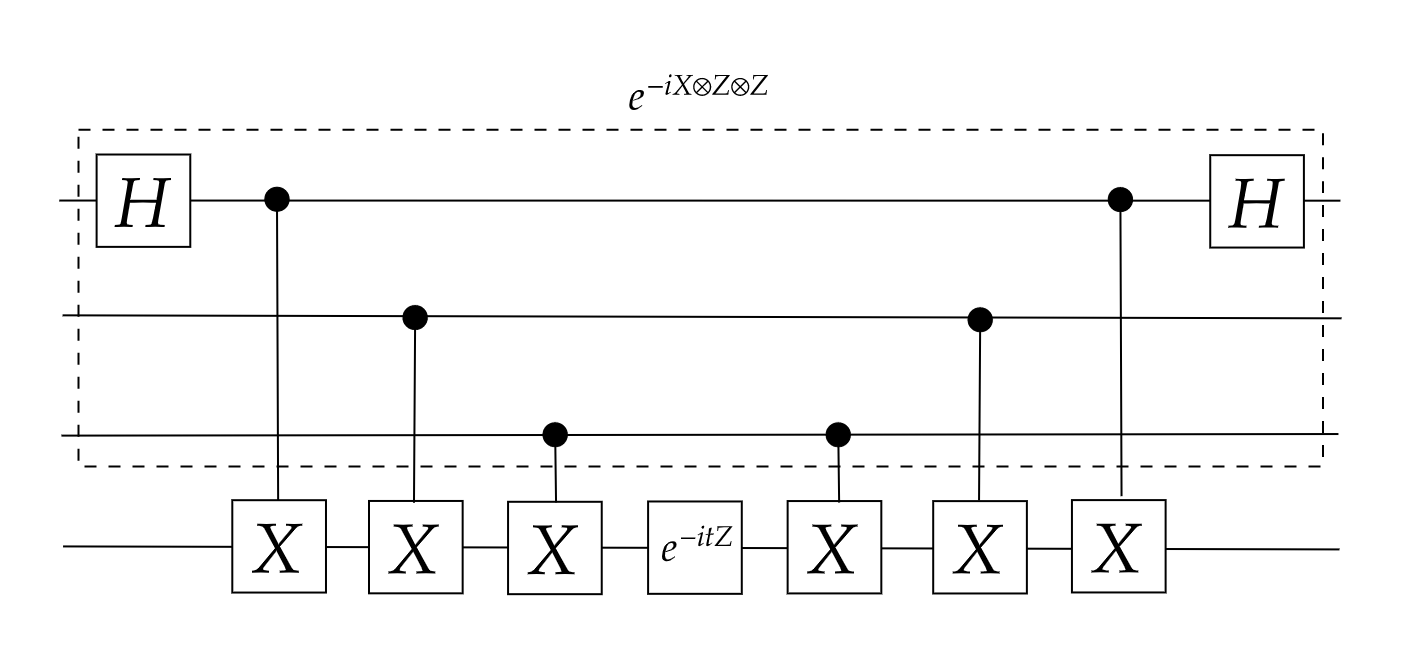


First, let's try the method we tried in the case of commuting matrices, that is, by simulating them one after the other.

0.6387432958682493
0.6387432958682493
0.6387432958682494
0.6387432958682498
0.6387432958682498
0.6387432958682498
0.6387432958682494
0.6387432958682498


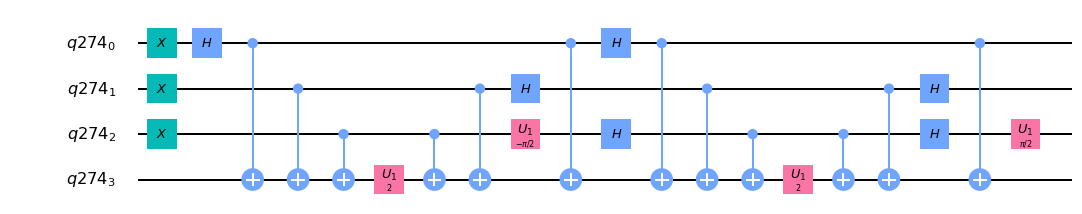

In [ ]:
# Assign t = 2
t = 1

# Actual matrix is given as
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), X_gate)))

for i in range(8):

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  qr = QuantumRegister(4)
  qc = QuantumCircuit(qr)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      qc.x(j)

  # Apply H1
  qc.h(0)

  qc.cnot(0, 3)
  qc.cnot(1, 3)
  qc.cnot(2, 3)
  qc.u1(2 * t, 3)
  qc.cnot(2, 3)
  qc.cnot(1, 3)
  qc.cnot(0, 3)

  qc.h(0)
  
  # Apply H2
  qc.u1(-np.pi/2, 2)
  qc.h(1)
  qc.h(2)

  qc.cnot(0, 3)
  qc.cnot(1, 3)
  qc.cnot(2, 3)
  qc.u1(2 * t, 3)
  qc.cnot(2, 3)
  qc.cnot(1, 3)
  qc.cnot(0, 3)

  qc.h(1)
  qc.h(2)
  qc.u1(np.pi/2, 2)

  # Compute the state vector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()
  
  # Disply the norm. Note that the global phases that each of the U1 gates brings in have to be removed. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm((np.exp(-1j * t * 2) * statevector[:8]) - actual_matrix[:,i]) ** 2)

# Display the circuit
qc.draw(output = "mpl")

We can see that, for each column of the gate, we differ by the actual matrix by around $0.63$. 

Now, let's try an improved method, which is given by

\begin{equation}
  e ^ {-it (H_1 + H_2)} \approx \Big( e ^ {\frac{ -it H_1}{r} } e ^ {\frac{ -it H_2}{r} } \Big)^r
\end{equation}

for an integer $r$.

First, let's take $r = 2$. 

0.13134095292938164
0.1313409529293817
0.13134095292938153
0.1313409529293816
0.13134095292938175
0.13134095292938172
0.1313409529293817
0.1313409529293817


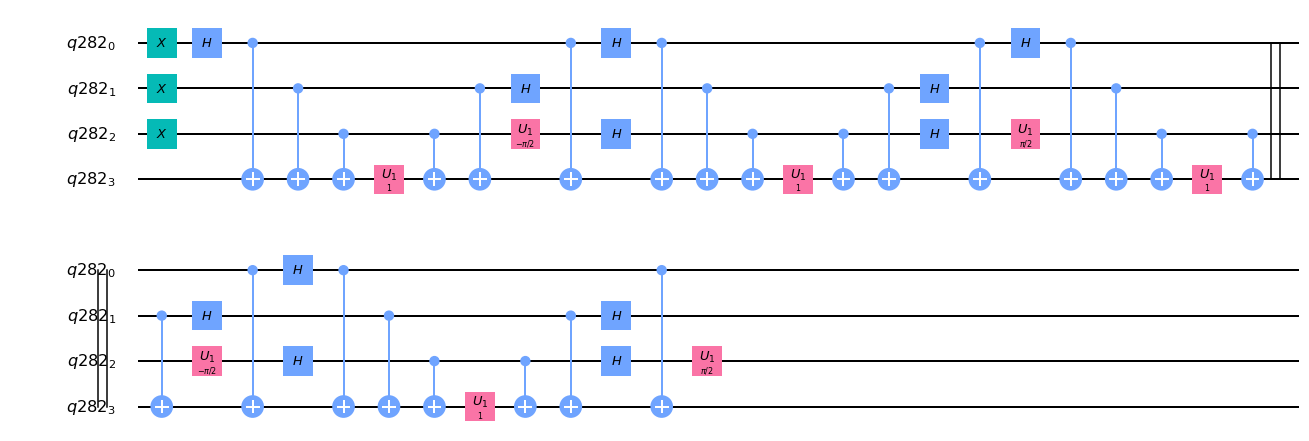

In [ ]:
# Assign t = 1, r = 2
t = 1
r = 2

# Prepare the actual_matrix
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), X_gate)))

for i in range(8):

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  qr = QuantumRegister(4)
  qc = QuantumCircuit(qr)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      qc.x(j)

  for j in range(r):

    # Apply H1
    qc.h(0)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(2 * t / r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(0)
    
    # Apply H2
    qc.u1(-np.pi/2, 2)
    qc.h(1)
    qc.h(2)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(2 * t / r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(1)
    qc.h(2)
    qc.u1(np.pi/2, 2)

  # Compute the state vector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()
  
  # Disply the norm. Note that the global phases that each of the U1 gates brings in have to be removed. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm((np.exp(-1j * t * 2) * statevector[:8]) - actual_matrix[:,i]) ** 2)

# Display the circuit
qc.draw(output = "mpl")

We can see that we have brought down the error to around $0.13$

Now, let's try with r = 3.

0.056038484028520665
0.05603848402852072
0.05603848402852064
0.05603848402852069
0.05603848402852064
0.056038484028520616
0.05603848402852062
0.05603848402852062


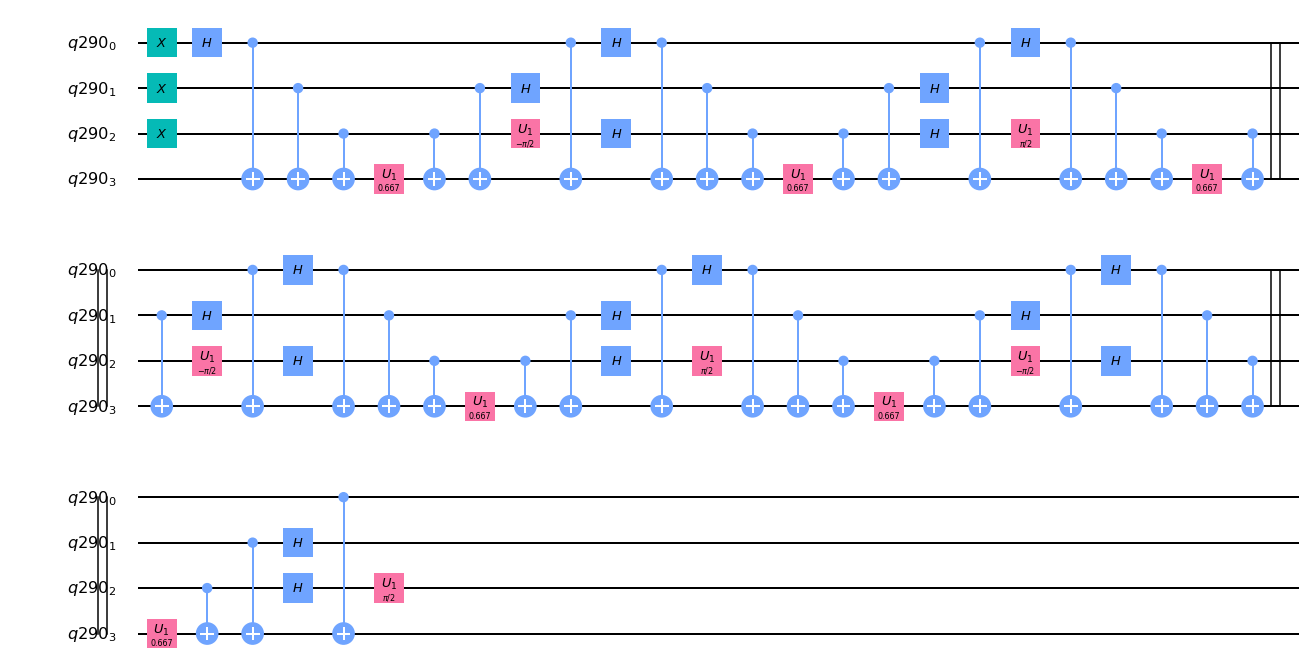

In [ ]:
# Assign t = 1, r = 2
t = 1
r = 3

# Prepare the actual_matrix
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), X_gate)))

for i in range(8):

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  qr = QuantumRegister(4)
  qc = QuantumCircuit(qr)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      qc.x(j)

  for j in range(r):

    # Apply H1
    qc.h(0)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(2 * t / r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(0)
    
    # Apply H2
    qc.u1(-np.pi/2, 2)
    qc.h(1)
    qc.h(2)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(2 * t / r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(1)
    qc.h(2)
    qc.u1(np.pi/2, 2)

  # Compute the state vector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()
  
  # Disply the norm. Note that the global phases that each of the U1 gates brings in have to be removed. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm((np.exp(-1j * t * 2) * statevector[:8]) - actual_matrix[:,i]) ** 2)

# Display the circuit
qc.draw(output = "mpl")

We have brought down the error further to around $0.05$.

Next we shall try an even better method. In this case, we shall try simulating $H$ as

\begin{equation}
  \begin{split}
    e ^ {-it (H_1 + H_2)} \approx& \Big( e ^ {\frac{ -it H_1}{2r} } e ^ {\frac{ -it H_2}{2r} } e ^ {\frac{ -it H_2}{2r} } e ^ {\frac{ -it H_1}{2r} } \Big)^r 
  \end{split}
\end{equation}


We start with $r = 2$.

0.022829346509210223
0.022829346509210247
0.022829346509210122
0.022829346509210046
0.022829346509210112
0.022829346509210122
0.022829346509210188
0.022829346509210122


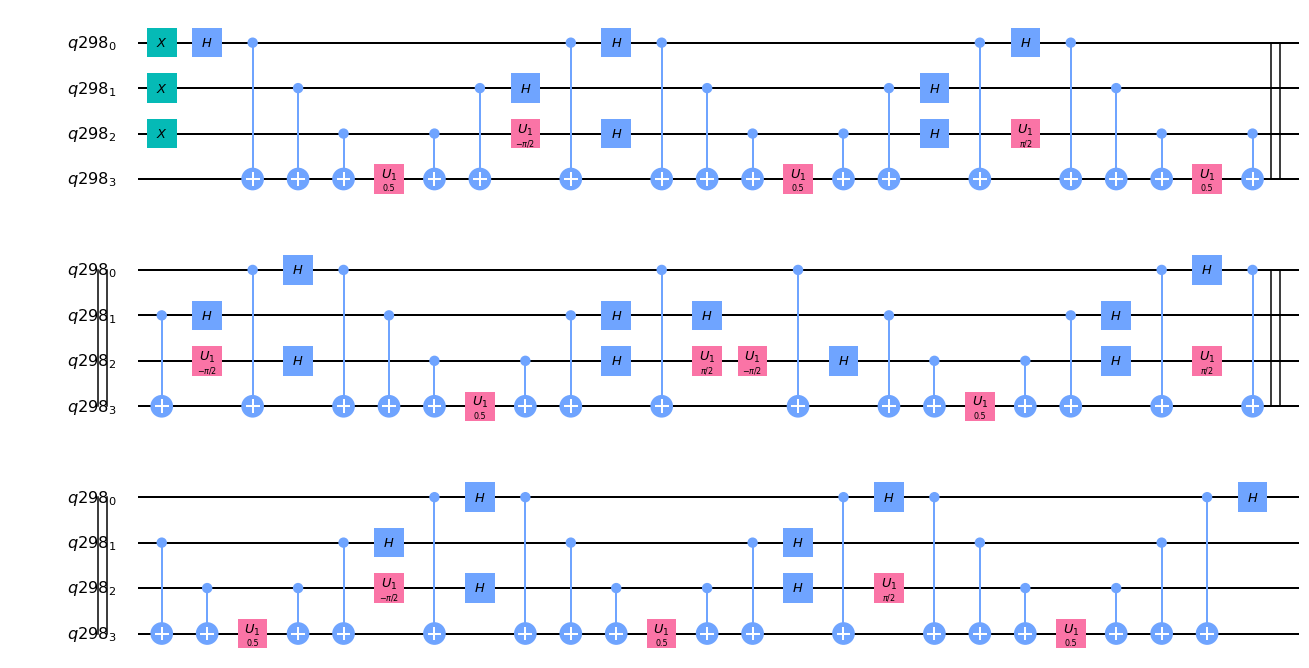

In [ ]:
# Assign r and t values
r = 2
t = 1

# Prepare actual_matrix
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), X_gate)))


for i in range(8):

  # Convert i from decimal to binary
  bina = Binary(i,3)
  bina.reverse()

  # Prepare the circuit
  qr = QuantumRegister(4)
  qc = QuantumCircuit(qr)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      qc.x(j)
      
  for j in range(r):

    # Apply H1
    qc.h(0)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(t/r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(0)

    # Apply H2
    qc.u1(-np.pi/2, 2)
    qc.h(1)
    qc.h(2)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(t/ r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(1)
    qc.h(2)
    qc.u1(np.pi/2, 2)

  for j in range(r):
    # Apply H2
    qc.u1(-np.pi/2, 2)
    qc.h(1)
    qc.h(2)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(t/ r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(1)
    qc.h(2)
    qc.u1(np.pi/2, 2)

    # Apply H1
    qc.h(0)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(t/r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(0)


  # Compute the state vector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()
  print(np.linalg.norm(((np.exp(-1j * 2 * t)) * statevector[:8]) - ans_mat[:,i]) ** 2)

# DIsplay the circuit
qc.draw(output = "mpl")



This is better approximation than both our previous attempts. So what about $r = 3$?

0.01000599191583632
0.010005991915836343
0.010005991915836296
0.01000599191583626
0.010005991915836288
0.010005991915836263
0.010005991915836301
0.010005991915836286


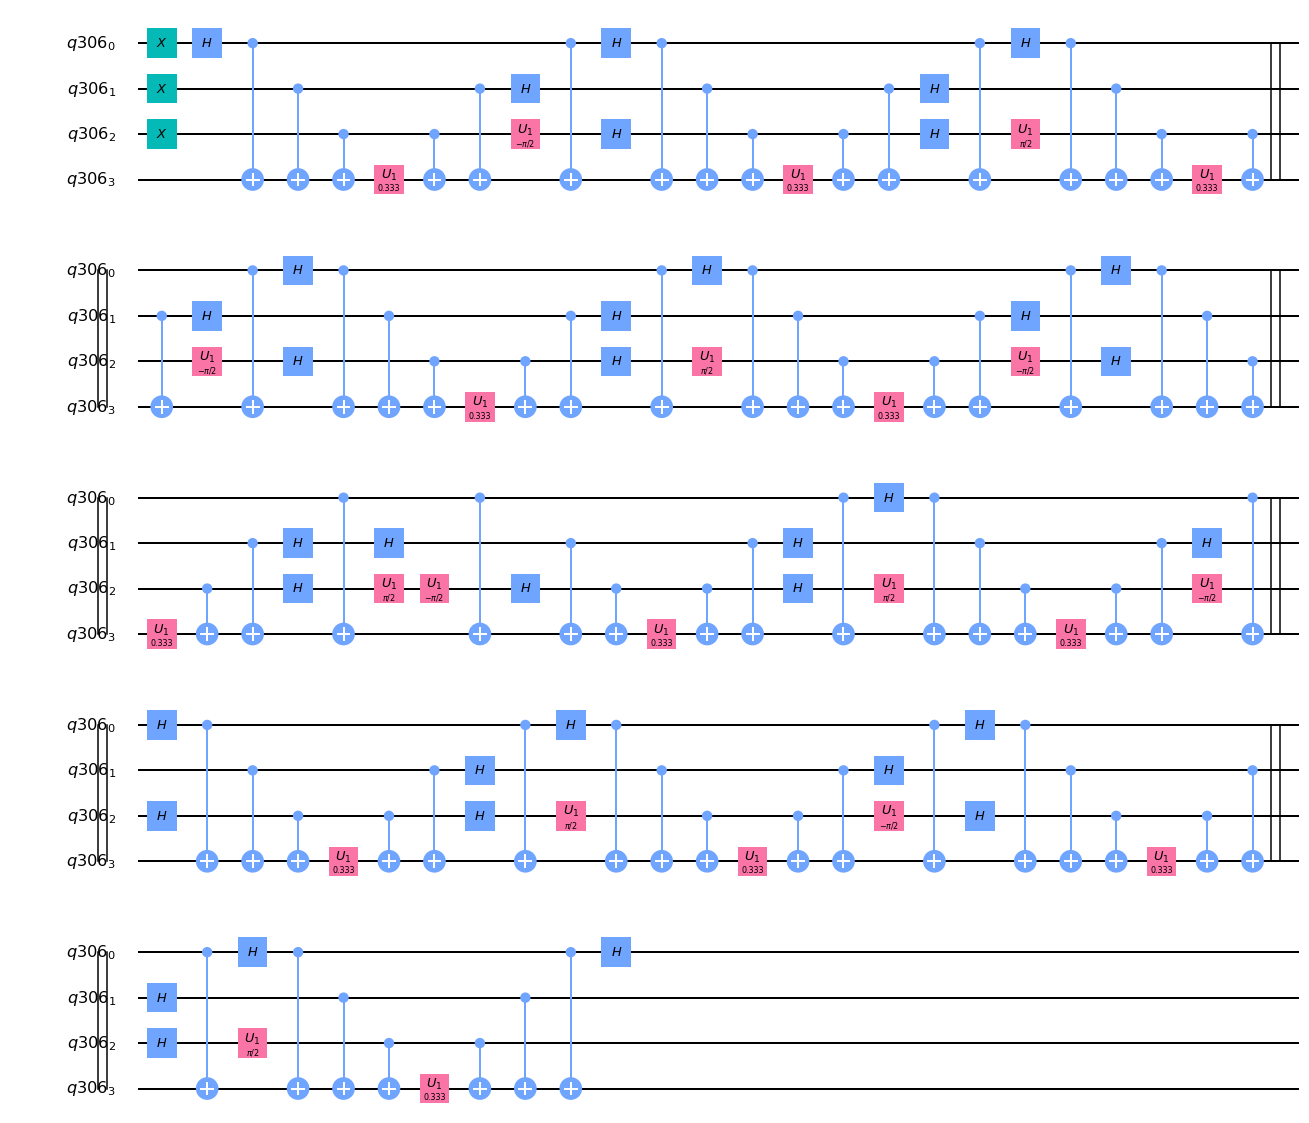

In [ ]:
# Assign r and t values
r = 3
t = 1

# Prepare actual_matrix
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), X_gate)))


for i in range(8):

  # Convert i from decimal to binary
  bina = Binary(i,3)
  bina.reverse()

  # Prepare the circuit
  qr = QuantumRegister(4)
  qc = QuantumCircuit(qr)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      qc.x(j)
      
  for j in range(r):

    # Apply H1
    qc.h(0)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(t/r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(0)

    # Apply H2
    qc.u1(-np.pi/2, 2)
    qc.h(1)
    qc.h(2)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(t/ r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(1)
    qc.h(2)
    qc.u1(np.pi/2, 2)

  for j in range(r):
    # Apply H2
    qc.u1(-np.pi/2, 2)
    qc.h(1)
    qc.h(2)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(t/ r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(1)
    qc.h(2)
    qc.u1(np.pi/2, 2)

    # Apply H1
    qc.h(0)

    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(2, 3)
    qc.u1(t/r, 3)
    qc.cnot(2, 3)
    qc.cnot(1, 3)
    qc.cnot(0, 3)

    qc.h(0)


  # Compute the state vector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()
  print(np.linalg.norm(((np.exp(-1j * 2 * t)) * statevector[:8]) - ans_mat[:,i]) ** 2)

# DIsplay the circuit
qc.draw(output = "mpl")



Much better.